# Machine Learning - Precios Propiedades (Versión 2)

In [ ]:
import pandas as pd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. Lectura de datos

In [ ]:
DIR = "/content/drive/MyDrive/DATA MINING/fcen-dm-2025-prediccion-precio-de-propiedades/entrenamiento"

In [ ]:
df_ent = pd.read_csv(f"{DIR}/entrenamiento.csv", index_col="id")
df_ent.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,price
id,,,,,,,,,,,,,,,,,,,,,
556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,NaN,...,2.0,NaN,NaN,USD,NaN,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta,259000.0
257134,Propiedad,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Argentina,Capital Federal,Boedo,NaN,...,1.0,74.0,47.0,USD,NaN,PH Venta Boedo 2 amb Patio,Corredor Responsable: MARCELO TRUJILLO - CPI ...,PH,Venta,140000.0
521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Argentina,Capital Federal,Almagro,NaN,...,1.0,66.0,64.0,USD,NaN,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta,173000.0
383947,Propiedad,2019-10-23,2019-11-08,2019-10-23,-58.420780,-34.608640,Argentina,Capital Federal,Almagro,NaN,...,1.0,55.0,55.0,USD,NaN,Depto.tipo casa de 3 ambientes en Venta en Alm...,"Muy Lindo ph al contrafrente con 2 patios!, 80...",PH,Venta,155000.0
986212,Propiedad,2019-08-01,2019-08-14,2019-08-01,-58.371394,-34.621835,Argentina,Capital Federal,San Telmo,NaN,...,1.0,42.0,42.0,USD,NaN,Ph en edificio de estilo Frances . 2 dormitori...,PH en Edificio Frances en Estado original!!!al...,PH,Venta,74000.0


In [ ]:
# cantidad de filas y columnas
df_ent.shape

(985180, 24)

## 1. Entender los datos (AID)

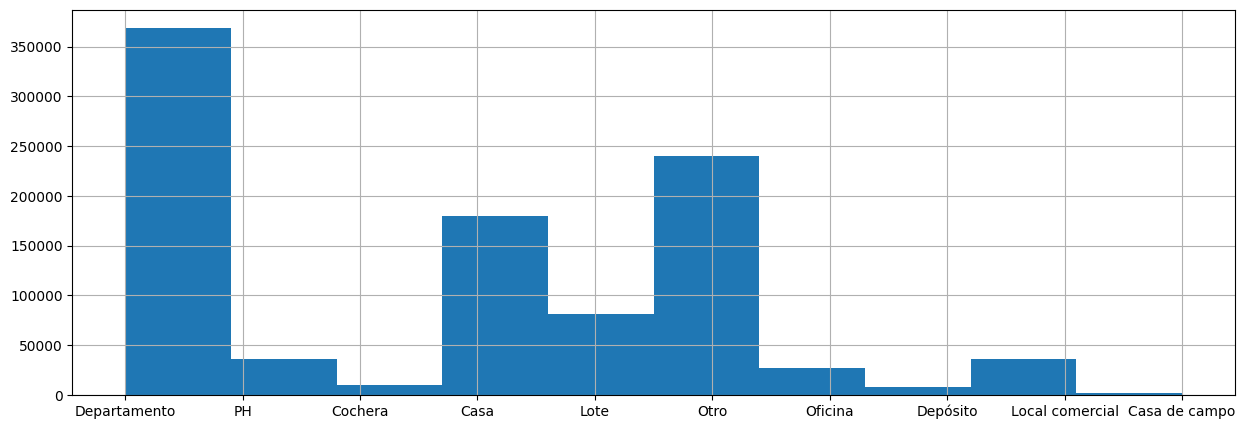

In [ ]:
df_ent["property_type"].hist(figsize=(15,5));

## 2. Limpiar y transformar los datos (MD)

In [ ]:
df_ent = df_ent[df_ent["price"].notna()].copy()

# 2) Aplicamos los filtros de país, moneda, operación, tipo y jurisdicción
df_ent = df_ent.loc[
    (df_ent["l1"] == "Argentina") &
    (df_ent["currency"].isin(["USD", "ARS"]))&
    (df_ent["operation_type"] == "Venta") &
    (df_ent["property_type"].isin(["Casa", "Departamento","Cochera"])) &
    (df_ent["l2"] == "Capital Federal")
].copy()

df_ent = df_ent.drop([
    "ad_type", "l6", "title", "description", "start_date", "end_date",
    "created_on", "currency", "price_period", "operation_type",
    "l1", "l2", "l5"
], axis=1)

print(df_ent.shape)

(104839, 11)


In [ ]:
df_ent.head()

,lat,lon,l3,l4,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price
id,,,,,,,,,,,
556713,-58.442399,-34.573623,Colegiales,NaN,3.0,2.0,2.0,NaN,NaN,Departamento,259000.0
521738,-58.429983,-34.607225,Almagro,NaN,3.0,2.0,1.0,66.0,64.0,Departamento,173000.0
499733,-58.404054,-34.599623,Barrio Norte,NaN,3.0,NaN,2.0,91.0,86.0,Departamento,190000.0
76927,-58.507339,-34.590882,Villa Devoto,NaN,2.0,NaN,2.0,NaN,NaN,Departamento,159900.0
473866,-58.421650,-34.588602,Palermo,NaN,3.0,2.0,2.0,80.0,80.0,Departamento,240000.0


In [ ]:
# 1) Calcula los logs (log1p para incluir ceros)
df_ent['log_price']           = np.log1p(df_ent['price'])
df_ent['log_surface_total']   = np.log1p(df_ent['surface_total'])
df_ent['log_surface_covered'] = np.log1p(df_ent['surface_covered'])

# 2) Define percentiles extremos (ej. 1 % – 99 %)
qs = {}
for col in ['log_price','log_surface_total','log_surface_covered']:
    qs[col] = df_ent[col].quantile([0.05, 0.95]).values  # [q1, q99]

# 3) Crea máscara para quedarte solo con filas dentro de esos rangos
mask = (
    df_ent['log_price'].between( *qs['log_price'] ) &
    df_ent['log_surface_total'].between( *qs['log_surface_total'] ) &
    df_ent['log_surface_covered'].between( *qs['log_surface_covered'] )
)

# 4) Filtra el DataFrame
df_ent = df_ent.loc[mask].copy()

# Elimina las columnas de log si no las necesitas más
df_ent.drop(columns=['log_price','log_surface_total','log_surface_covered'],
                  inplace=True)

In [ ]:
# Eliminar si l3 y l4 están vacías
df_ent = df_ent.dropna(subset=["l3", "l4"], how="all")

In [ ]:
# Crear columna l4 a partir de l3
df_ent["l4"] = df_ent["l4"].fillna(df_ent["l3"])
df_ent = df_ent.drop(columns="l3")

In [ ]:
# Eliminar registros que no tengan ni lat ni lon ni l4
condicion = df_ent["lat"].isna() & df_ent["lon"].isna() & df_ent["l4"].isna()
df_ent = df_ent[~condicion]

In [ ]:
# Eliminar si tienen rooms y bedrooms en NaN
condicion = (
    df_ent["rooms"].isna() &
    df_ent["bedrooms"].isna())

df_ent = df_ent[~condicion]

In [ ]:
df_ent["ratio_cubierta"] = df_ent["surface_covered"] / df_ent["surface_total"]
df_ent["diferencia_superficie"] = df_ent["surface_total"] - df_ent["surface_covered"]

In [ ]:
map_l3 = {barrio: i for i, barrio in enumerate(sorted(df_ent["l4"].dropna().unique()))}
df_ent["l4_codificado"] = df_ent["l4"].map(map_l3)


In [ ]:
map_property = {tipo: i for i, tipo in enumerate(sorted(df_ent["property_type"].dropna().unique()))}

df_ent["property_type_codificado"] = df_ent["property_type"].map(map_property).fillna(-1)

df_ent = df_ent.drop(columns=["property_type"])


In [ ]:
df_ent.loc[df_ent['surface_covered'] > df_ent['surface_total'] * 1.5, 'surface_covered'] = df_ent['surface_total']

df_ent['lat'] = df_ent['lat'].mask(df_ent['lat'] == 0, df_ent['lat'].mean())
df_ent['lon'] = df_ent['lon'].mask(df_ent['lon'] == 0, df_ent['lon'].mean())

medianas_ent = df_ent.groupby('property_type_codificado')['rooms'].median()
df_ent['rooms'] = df_ent.apply(
    lambda row: medianas_ent[row['property_type_codificado']] if row['rooms'] == 0 else row['rooms'],
    axis=1
)

df_ent.loc[df_ent['bathrooms'] > df_ent['rooms'], 'bathrooms'] = df_ent['rooms']


In [ ]:
# 1) Sólo imputamos donde bedrooms sea NaN y rooms no lo sea
mask = df_ent["bedrooms"].isna() & df_ent["rooms"].notna()
df_ent.loc[mask, "bedrooms"] = df_ent.loc[mask, "rooms"]

In [ ]:
# Calcula la mediana de bedrooms y redondéala a entero
median_bed = int(round(df_ent["bedrooms"].median()))

# Imputa los NaN con esa mediana redondeada
df_ent["bedrooms"].fillna(median_bed, inplace=True)


<ipython-input-47-ded5016b0793>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ent["bedrooms"].fillna(median_bed, inplace=True)


In [ ]:
mask_bath = df_ent["bathrooms"].isna() & df_ent["rooms"].notna()
df_ent.loc[mask_bath, "bathrooms"] = df_ent.loc[mask_bath, "rooms"]

In [ ]:
# 1) Imputa en df_ent donde rooms sea NaN y bedrooms NO sea NaN:
mask_rooms = df_ent["rooms"].isna() & df_ent["bedrooms"].notna()
df_ent.loc[mask_rooms, "rooms"] = df_ent.loc[mask_rooms, "bedrooms"] + 1

In [ ]:
condicion = df_ent["lat"].isna() & df_ent["lon"].isna()
df_ent = df_ent[~condicion]

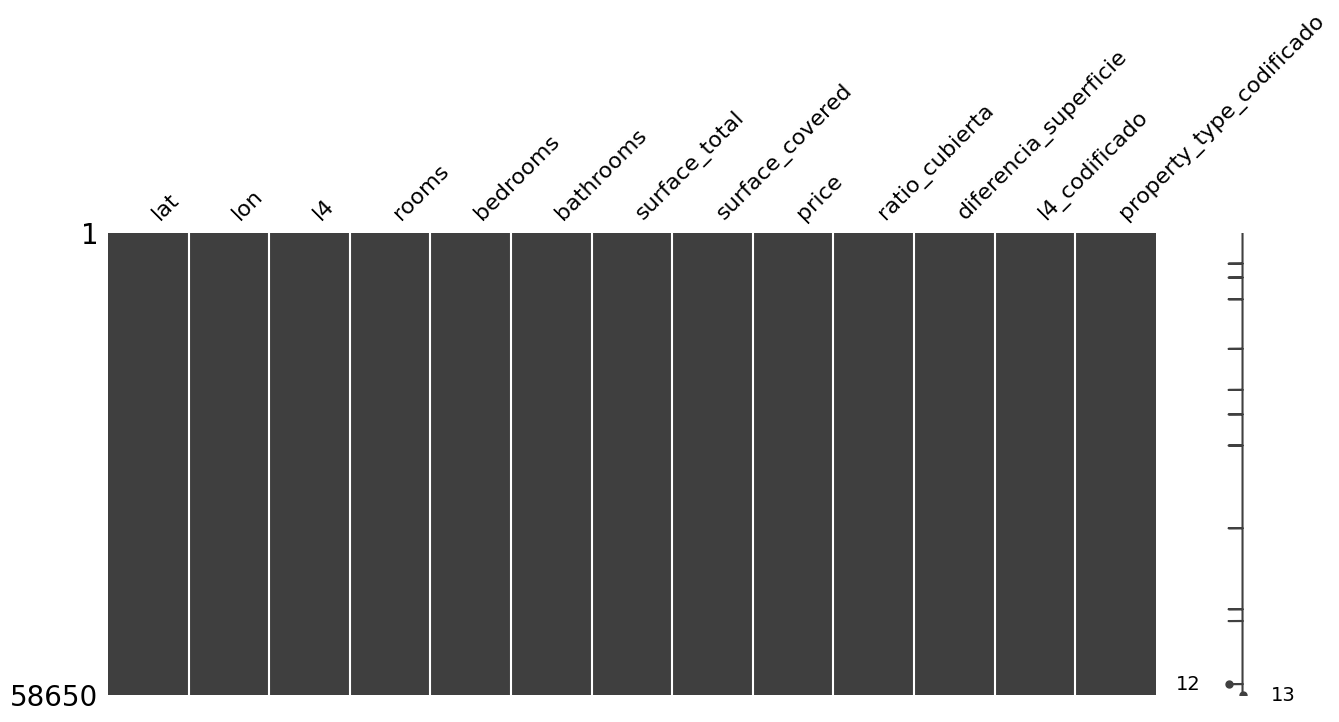

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

# Mostrar la matriz de valores faltantes
msno.matrix(df_ent, figsize=(15, 6))
plt.show()

In [ ]:
df_ent = df_ent.fillna(0)

## 3. Entrenamiento del modelos (AA)

In [ ]:
# Me quedo con las columnas numéricas o booleanas solamente
df_ent = df_ent.select_dtypes(['number', 'bool'])
print(df_ent.columns)
X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

Index(['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'ratio_cubierta', 'diferencia_superficie',
       'l4_codificado', 'property_type_codificado'],
      dtype='object')


In [ ]:
### Versión con train/test split
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

#best_rf = None
best_score_test = 1000000


for n_estimators in [10, 50, 100]:

    # for max_depth in [3, 5, 8, 10, 12]:
    # 	reg = sk.ensemble.GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    for max_depth in [5, 10, 20]:
        reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42,min_samples_leaf=10,min_samples_split=20)

        # Entrenamos el modelo
        _ = reg.fit(X_train, y_train)

        # Cálculo del error en entrenamiento (train)
        y_pred = reg.predict(X_train)
        score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)

        # Cálculo del error en prueba (test)
        y_pred = reg.predict(X_test)
        score_test  = sk.metrics.root_mean_squared_error(y_test,  y_pred)

        #best_rf = reg

        best_score_test = min(best_score_test, score_test)

        print(f"{n_estimators=} -- {max_depth=} --> {score_train=:.2f} - {score_test=:.2f} - {best_score_test=:.2f}")

n_estimators=10 -- max_depth=5 --> score_train=61175.86 - score_test=61592.69 - best_score_test=61592.69
n_estimators=10 -- max_depth=10 --> score_train=43986.53 - score_test=46314.17 - best_score_test=46314.17
n_estimators=10 -- max_depth=20 --> score_train=36534.21 - score_test=41611.56 - best_score_test=41611.56
n_estimators=50 -- max_depth=5 --> score_train=61229.66 - score_test=61659.64 - best_score_test=41611.56
n_estimators=50 -- max_depth=10 --> score_train=43605.51 - score_test=45948.80 - best_score_test=41611.56
n_estimators=50 -- max_depth=20 --> score_train=35911.21 - score_test=41127.53 - best_score_test=41127.53
n_estimators=100 -- max_depth=5 --> score_train=61054.59 - score_test=61459.85 - best_score_test=41127.53
n_estimators=100 -- max_depth=10 --> score_train=43476.41 - score_test=45858.52 - best_score_test=41127.53
n_estimators=100 -- max_depth=20 --> score_train=35699.44 - score_test=40991.99 - best_score_test=40991.99


## 4. Dataframe A Predecir

In [ ]:
df_ap = pd.read_csv(f"/content/drive/MyDrive/DATA MINING/fcen-dm-2025-prediccion-precio-de-propiedades/a_predecir.csv", index_col="id")
df_ap.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,price
id,,,,,,,,,,,,,,,,,,,,,
1068,Propiedad,2020-06-21,2020-06-27,2020-06-21,NaN,NaN,Argentina,Capital Federal,Palermo,Palermo Viejo,...,1.0,286.0,160.0,USD,NaN,Casa de 4 ambientes en Venta en Palermo viejo,TRIPLEX EN MEDIO TERRENO DE 4 AMB MUY AMPLIOS...,Casa,Venta,NaN
1069,Propiedad,2020-06-21,2020-06-27,2020-06-21,-58.426576,-34.590987,Argentina,Capital Federal,Palermo,NaN,...,5.0,444.0,270.0,USD,NaN,Casa de 8 ambientes en Venta en Palermo,OPORTUNIDAD!! Edificio en Block desarrollado e...,Casa,Venta,NaN
1073,Propiedad,2020-06-21,2020-06-24,2020-06-21,-58.479808,-34.631266,Argentina,Capital Federal,Floresta,NaN,...,2.0,166.0,120.0,USD,NaN,Venta de casa en PH en Floresta,Casa con muy buena distribución y de amplios a...,Casa,Venta,NaN
1082,Propiedad,2020-06-21,2020-06-27,2020-06-21,-58.437889,-34.603291,Argentina,Capital Federal,Villa Crespo,NaN,...,3.0,352.0,185.0,USD,NaN,Casa de 5 ambientes en Venta en Villa crespo,SON 185 METROS CUBIERNTOS CON COCHERA MAS PATI...,Casa,Venta,NaN
1091,Propiedad,2020-06-21,2020-06-27,2020-06-21,-58.476461,-34.602494,Argentina,Capital Federal,Villa del Parque,NaN,...,2.0,168.0,106.0,USD,NaN,Venta de casa de tres ambientes en Villa del P...,"Hermosa casa ubicada en zona residencial, sobr...",Casa,Venta,NaN


In [ ]:
df_ap.shape

(7012, 24)

In [ ]:
df_ap = df_ap.drop(columns=["ad_type", "l6", "title", "description", "start_date", "end_date", "created_on", "currency", "price_period", "operation_type","l1","l5","l2"])

In [ ]:
# Pasar data de l3 a l4
df_ap['l4'] = df_ap['l4'].fillna(df_ap['l3'])
df_ap.drop(columns='l3', inplace=True)

In [ ]:
df_ap.loc[df_ap.index[97], 'l4'] = 'Boca'
df_ap.loc[df_ap.index[235], 'l4'] = 'Boca'
df_ap.loc[df_ap.index[311], 'l4'] = 'Villa Devoto'
df_ap.loc[df_ap.index[2253], 'l4'] = 'Nuñez'
df_ap.loc[df_ap.index[2971], 'l4'] = 'Villa Luro'
df_ap.loc[df_ap.index[4256], 'l4'] = 'Palermo'
df_ap.loc[df_ap.index[6911], 'l4'] = 'Villa Urquiza'
df_ap.loc[df_ap.index[2353], 'l4'] = 'Villa Luro'

In [ ]:
df_ap['surface_total'] = df_ap['surface_total'].fillna(df_ap['surface_covered'])
df_ap['surface_covered'] = df_ap['surface_covered'].fillna(df_ap['surface_total'])


In [ ]:
# 1) Bedrooms: si falta bedrooms pero hay rooms
mask_bed = df_ap["bedrooms"].isna() & df_ap["rooms"].notna()
df_ap.loc[mask_bed, "bedrooms"] = df_ap.loc[mask_bed, "rooms"]

In [ ]:
# Rellenar cualquier NaN restante en bedrooms con la mediana redondeada
median_bed = int(round(df_ap["bedrooms"].median(skipna=True)))
df_ap["bedrooms"].fillna(median_bed, inplace=True)

<ipython-input-75-dee850e627c2>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ap["bedrooms"].fillna(median_bed, inplace=True)


In [ ]:
# 2) Bathrooms: si falta bathrooms pero hay rooms
mask_bath = df_ap["bathrooms"].isna() & df_ap["rooms"].notna()
df_ap.loc[mask_bath, "bathrooms"] = df_ap.loc[mask_bath, "rooms"]

In [ ]:
# Rellenar cualquier NaN restante en bathrooms con la mediana redondeada
median_bath = int(round(df_ap["bathrooms"].median(skipna=True)))
df_ap["bathrooms"].fillna(median_bath, inplace=True)


<ipython-input-76-5206fa2ae6bf>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ap["bathrooms"].fillna(median_bath, inplace=True)


In [ ]:
# 3) Rooms: si falta rooms pero hay bedrooms, asumimos rooms = bedrooms + 1
mask_rooms = df_ap["rooms"].isna() & df_ap["bedrooms"].notna()
df_ap.loc[mask_rooms, "rooms"] = df_ap.loc[mask_rooms, "bedrooms"] + 1

In [ ]:
# Rellenar cualquier NaN restante en rooms con la mediana redondeada
median_rooms = int(round(df_ap["rooms"].median(skipna=True)))
df_ap["rooms"].fillna(median_rooms, inplace=True)

<ipython-input-77-05618f07b667>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ap["rooms"].fillna(median_rooms, inplace=True)


In [ ]:
medianas_lat = df_ap.groupby("l4")["lat"].median()
medianas_lon = df_ap.groupby("l4")["lon"].median()

df_ap["lat"] = df_ap["lat"].fillna(df_ap["l4"].map(medianas_lat))
df_ap["lon"] = df_ap["lon"].fillna(df_ap["l4"].map(medianas_lon))



In [ ]:
df_ap["ratio_cubierta"] = df_ap["surface_covered"] / df_ap["surface_total"]
df_ap["diferencia_superficie"] = df_ap["surface_total"] - df_ap["surface_covered"]

In [ ]:
df_ap["l4_codificado"] = df_ap["l4"].map(map_l3).fillna(-1)

In [ ]:
df_ap["property_type_codificado"] = df_ap["property_type"].map(map_property).fillna(-1)

df_ap = df_ap.drop(columns=["property_type"])


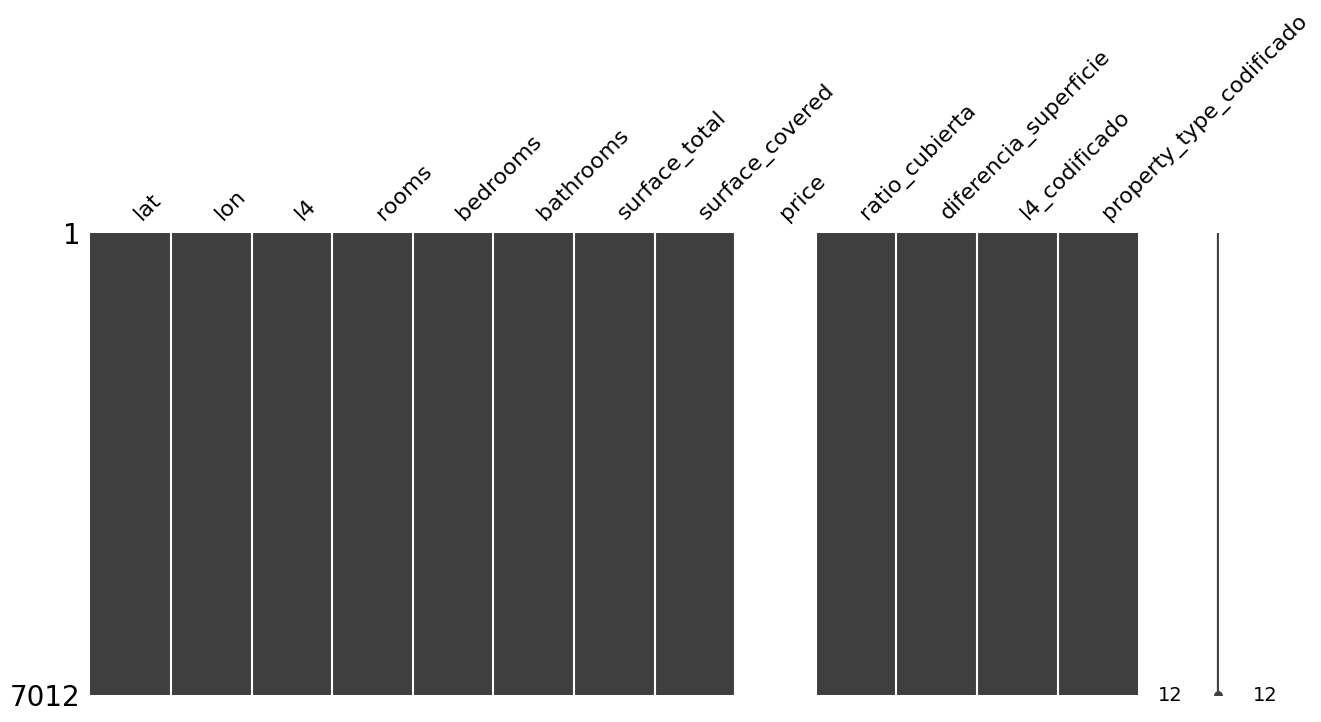

In [ ]:
# Mostrar la matriz de valores faltantes
msno.matrix(df_ap, figsize=(15, 6))
plt.show()

In [ ]:
X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

# Entrenamos el modelo con todos los datos de entrenamiento.csv
reg.fit(X, y)

RandomForestRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=20,
                      n_jobs=-1, random_state=42)

In [ ]:
# Hacemos en df_ap la misma limpieza que en df_ent
df_ap.loc[df_ap['surface_covered'] > df_ap['surface_total'] * 1.5, 'surface_covered'] = df_ap['surface_total']

df_ap['lat'] = df_ap['lat'].mask(df_ap['lat'] == 0, df_ap['lat'].mean())
df_ap['lon'] = df_ap['lon'].mask(df_ap['lon'] == 0, df_ap['lon'].mean())

medianas_ap = df_ap.groupby('property_type_codificado')['rooms'].median()
df_ap['rooms'] = df_ap.apply(
    lambda row: medianas_ap[row['property_type_codificado']] if row['rooms'] == 0 else row['rooms'],
    axis=1
)

df_ap.loc[df_ap['bathrooms'] > df_ap['rooms'], 'bathrooms'] = df_ap['rooms']


df_ap = df_ap.fillna(0)

df_ap = df_ap.select_dtypes('number')

X_ap = df_ap[X.columns]
# y_ap = df_ap['price'] # no es necesario!

# Predecimos los precios del dataset a predecir
y_pred_ap = reg.predict(X_ap)
y_pred_ap

array([448514.2957576 , 570005.35262463, 231380.87569318, ...,
       539701.48708541, 201056.3417652 , 242254.62038022])

In [ ]:
X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

# Entrenamos el modelo con todos los datos de entrenamiento.csv, con los mejores hiperparámetros
n_estimators = 100
max_depth = 20
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
_ = reg.fit(X, y)

# Importancia de las columnas y análisis de los errores.

In [ ]:
# Importancia de las columnas
pd.DataFrame({"importance": reg.feature_importances_}, index=X.columns).sort_values(by="importance", ascending=False)

,importance
surface_covered,0.513345
lon,0.155699
surface_total,0.153975
lat,0.100582
ratio_cubierta,0.016611
bathrooms,0.016082
l4_codificado,0.015946
diferencia_superficie,0.008995
rooms,0.008731
bedrooms,0.005590


In [ ]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators = 100
max_depth = 20

reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
_ = reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

In [ ]:
X_test["error"] = abs(y_pred - y_test)
X_test["price"] = y_test
X_test["pred_price"] = y_pred
X_test.sort_values(by="error", ascending=False)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,ratio_cubierta,diferencia_superficie,l4_codificado,property_type_codificado,error,price,pred_price
id,,,,,,,,,,,,,,
967626,-58.478087,-34.584340,1.0,1.0,1.0,30.0,30.0,1.000000,0.0,60,2,602229.678476,690000.0,87770.321524
785317,-58.411101,-34.590522,3.0,2.0,1.0,86.0,82.0,0.953488,4.0,27,2,401859.606256,630000.0,228140.393744
59019,-58.473234,-34.540273,3.0,3.0,2.0,200.0,110.0,0.550000,90.0,25,2,364971.593175,750000.0,385028.406825
988855,-58.455402,-34.557104,4.0,3.0,4.0,142.0,142.0,1.000000,0.0,6,2,359155.385987,590000.0,230844.614013
185100,-58.519375,-34.599379,4.0,3.0,3.0,170.0,130.0,0.764706,40.0,50,2,314242.583333,770000.0,455757.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497207,-58.439808,-34.576955,2.0,1.0,1.0,106.0,106.0,1.000000,0.0,29,2,0.000000,440000.0,440000.000000
77553,-58.444796,-34.601100,5.0,4.0,2.0,179.0,164.0,0.916201,15.0,49,2,0.000000,137000.0,137000.000000
102284,-58.407963,-34.623207,3.0,2.0,2.0,88.0,80.0,0.909091,8.0,43,2,0.000000,110000.0,110000.000000
